In [24]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import skimage

from IPython import display
%matplotlib inline

tfk = tf.keras
tfkl = tf.keras.layers

# Load Data

In [2]:
from softlearning.models.state_estimation import (
    get_dumped_pkl_data
)
# images_path = '/root/nfs/kun1/users/justinvyu/data/fixed_data_with_states.pkl'

# from softlearning.misc.utils import PROJECT_PATH
# images_path = os.path.join(PROJECT_PATH,
#                            'goal_classifier',
#                            'vae_visible_claw_data.pkl')

images_path = '/nfs/kun1/users/justinvyu/data/vae_visible_claw_data_diff_angle_fixed_state_64.pkl'
images, states = get_dumped_pkl_data(images_path)

In [3]:
images.shape, states.shape

((500000, 64, 64, 3), (500000, 4))

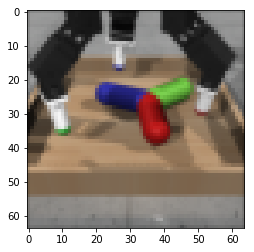

In [4]:
plt.imshow(images[0])

# Train state estimator on top of the VAE outputs

In [25]:
from softlearning.preprocessors.utils import get_vae_preprocessor
# encoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_encoder_weights_4_final.h5'
# decoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_decoder_weights_4_final.h5'

# encoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_encoder_weights.h5'
# decoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_decoder_weights.h5'

# encoder_weights_fn = '/nfs/kun1/users/justinvyu/pretrained_models/vae_64_dim_beta_2_visible_claw_l2_reg/encoder_64_dim_2.0_beta.h5'
# decoder_weights_fn = '/nfs/kun1/users/justinvyu/pretrained_models/vae_64_dim_beta_2_visible_claw_l2_reg/decoder_64_dim_2.0_beta.h5'
encoder_weights_fn = '/nfs/kun1/users/justinvyu/pretrained_models/vae_64_dim_beta_5_visible_claw_diff_angle/encoder_64_dim_5.0_beta.h5'
decoder_weights_fn = '/nfs/kun1/users/justinvyu/pretrained_models/vae_64_dim_beta_5_visible_claw_diff_angle/decoder_64_dim_5.0_beta.h5'
vae_preprocessor_params = {
    'type': 'VAEPreprocessor',
    'kwargs': {
        'encoder_path': encoder_weights_fn,
        'decoder_path': decoder_weights_fn,
        'trainable': False,
        'image_shape': (64, 64, 3),
#         'image_shape': (32, 32, 3),
        'latent_dim': 64,
        'include_decoder': False,
    }
}
convnet_preprocessor_params = {
    'type': 'ConvnetPreprocessor',
    'kwargs': {
        'conv_filters': (64, 64, 32, 32),
        'conv_kernel_sizes': (3, ) * 4,
        'conv_strides': (2, ) * 4,
        'normalization_type': None
    }
}

from softlearning.models.state_estimation import state_estimator_model
state_estimator = state_estimator_model(
    input_shape=(64, 64, 3),
    num_hidden_units=512,
    num_hidden_layers=2,
    preprocessor_params=convnet_preprocessor_params)
#     preprocessor_params=vae_preprocessor_params)
# state_estimator = state_estimator_model(
#     input_shape=(32, 32, 3),
#     num_hidden_units=512,
#     num_hidden_layers=4,
#     preprocessor=encoder)

In [26]:
state_estimator.summary()

Model: "state_estimator_preprocessor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convnet_preprocessor (Pickla (None, 512)               66432     
_________________________________________________________________
feedforward_state_est (Pickl (None, 4)                 527364    
Total params: 593,796
Trainable params: 593,796
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile
state_estimator.compile(optimizer=tf.keras.optimizers.Adam(3e-4), loss='mse')

In [ ]:
N_EPOCHS = 50

history = state_estimator.fit(
    x=images,
    y=states,
    batch_size=256,
    epochs=N_EPOCHS,
    validation_split=0.1
)

Train on 450000 samples, validate on 50000 samples
Epoch 1/50
450000/450000 [==============================] - 26s 59us/sample - loss: 0.0079 - val_loss: 0.0010
Epoch 2/50
450000/450000 [==============================] - 26s 58us/sample - loss: 7.5363e-04 - val_loss: 5.1011e-04
Epoch 3/50
450000/450000 [==============================] - 26s 57us/sample - loss: 4.8224e-04 - val_loss: 3.9701e-04
Epoch 4/50
450000/450000 [==============================] - 27s 60us/sample - loss: 3.6422e-04 - val_loss: 3.2708e-04
Epoch 5/50
450000/450000 [==============================] - 27s 60us/sample - loss: 2.8958e-04 - val_loss: 2.5176e-04
Epoch 6/50
450000/450000 [==============================] - 27s 59us/sample - loss: 2.3604e-04 - val_loss: 2.1865e-04
Epoch 7/50
450000/450000 [==============================] - 26s 58us/sample - loss: 2.0516e-04 - val_loss: 2.1740e-04
Epoch 8/50
450000/450000 [==============================] - 26s 57us/sample - loss: 1.7749e-04 - val_loss: 1.7246e-04
Epoch 9/50
45

# Show estimation errors

In [13]:
# Get samples to calculate metrics on
random_indices = np.random.choice(images.shape[0], size=10000)
test_images = images[random_indices]
test_labels = states[random_indices]
preds = state_estimator.predict(test_images)

In [14]:
pos_errors = []
angle_errors = []

degrees = lambda x: x * 180 / np.pi
def angle_distance(deg1, deg2):
    phi = np.abs(deg1 - deg2) % 360
    distance = 360 - phi if phi > 180 else phi
    return distance

for i, (test_img, label, pred) in enumerate(zip(test_images, test_labels, preds)):
    pos_error_xy = np.abs(label[:2] - pred[:2])
    pos_error = np.linalg.norm(pos_error_xy)
    pos_error = 15 * pos_error # free box is 30 cm, 15 on each side (-1 -> 1 --> -15 -> 15)
    
    true_angle = np.arctan2(label[3], label[2])
    true_angle = degrees(true_angle)
    pred_angle = np.arctan2(pred[3], pred[2])
    pred_angle = degrees(pred_angle)
    
    angle_error = angle_distance(true_angle, pred_angle)

    pos_errors.append(pos_error)
    angle_errors.append(angle_error)

mean_pos_error = np.mean(pos_errors)
mean_angle_error = np.mean(angle_errors)
print('MEAN POS ERROR (CM):', mean_pos_error)
print('MEAN ANGLE ERROR (degrees):', mean_angle_error)

MEAN POS ERROR (CM): 0.2946539807202713
MEAN ANGLE ERROR (degrees): 1.3754611036194437


In [15]:
def display_top_errors(errors, label_str=""):
    errors = np.array(errors)
    ind = np.argpartition(errors, -20)[-20:]
    ind = ind[np.argsort(errors[ind])]
    ind = np.flip(ind) # Order descending
    print(ind)
    top_errors = errors[ind]
    
    top_error_imgs, top_error_labels, top_error_preds = test_images[ind], test_labels[ind], preds[ind]
    for i, (error, img, label, pred) in enumerate(zip(top_errors,
                                                      top_error_imgs,
                                                      top_error_labels,
                                                      top_error_preds)):
        print('\n========== IMAGE #', i, '=========')
        plt.axis('off')
        plt.imshow(img)
        print('{} ERROR: {}\n\ntrue: {}\npred: {}'.format(label_str, error, label, pred))
        plt.show()

[ 757 4263 7958 8901 6886 8008 5963 7697 9258 9891 8869 7171 9302  265
 4041 4451 5631 3501 6892 6466]

========== IMAGE # 0 =========
POS (cm) ERROR: 2.0642623755765257

true: [-0.47828743  0.35798661 -0.99895063  0.04580009]
pred: [-0.5718447   0.25706282 -0.97458804 -0.0252132 ]


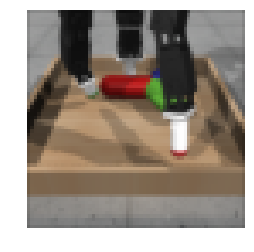


========== IMAGE # 1 =========
POS (cm) ERROR: 1.9794298409649698

true: [-0.83994318 -0.60171981  0.81137647  0.58452393]
pred: [-0.7158328  -0.55688024  0.82345355  0.55919707]


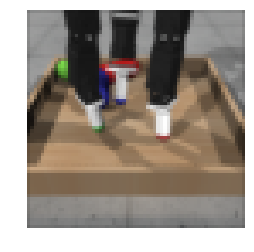


========== IMAGE # 2 =========
POS (cm) ERROR: 1.856086008600869

true: [-0.12180135  0.61084972  0.88915326  0.45760954]
pred: [-0.24515226  0.620643    0.8408034   0.5226687 ]


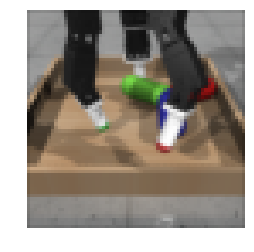


========== IMAGE # 3 =========
POS (cm) ERROR: 1.852191597223612

true: [-0.58740951 -0.58565215  0.87245697  0.48869095]
pred: [-0.696013   -0.5268945   0.85737973  0.55809474]


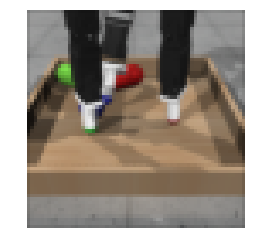


========== IMAGE # 4 =========
POS (cm) ERROR: 1.8332034413304197

true: [-0.78179995  0.57764564 -0.17170768 -0.98514794]
pred: [-0.732267    0.46591988 -0.18502523 -0.9778047 ]


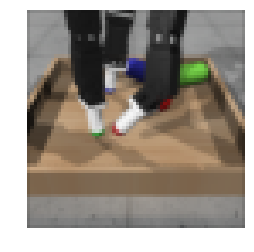


========== IMAGE # 5 =========
POS (cm) ERROR: 1.7792628883269606

true: [-0.40031448  0.59411182  0.9306018   0.36603318]
pred: [-0.5131447   0.5575131   0.9332195   0.32650924]


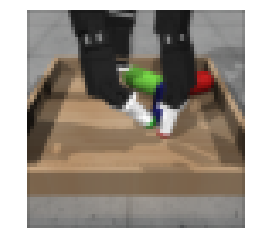


========== IMAGE # 6 =========
POS (cm) ERROR: 1.779094766743958

true: [-0.34397197 -0.25665144  0.83711741  0.54702326]
pred: [-0.46165738 -0.24190003  0.81536484  0.57006633]


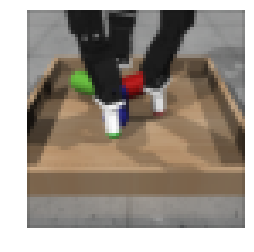


========== IMAGE # 7 =========
POS (cm) ERROR: 1.7707210327250402

true: [-0.81082418 -0.60570829 -0.78000839  0.62576905]
pred: [-0.7581717 -0.7113637 -0.672966   0.6740643]


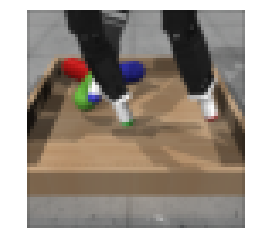


========== IMAGE # 8 =========
POS (cm) ERROR: 1.7582863643093107

true: [-0.88664733  0.62391296 -0.85457635  0.51932577]
pred: [-0.7811917   0.5727326  -0.83190393  0.567008  ]


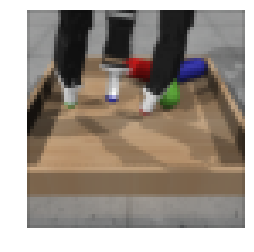


========== IMAGE # 9 =========
POS (cm) ERROR: 1.7428584041944417

true: [-0.60958037  0.54651476 -0.37118096 -0.92856055]
pred: [-0.7208218   0.5800646  -0.33337325 -0.9504455 ]


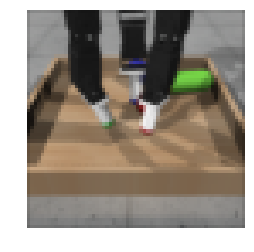


========== IMAGE # 10 =========
POS (cm) ERROR: 1.7229473058010547

true: [-0.02110418  0.20132828 -0.14728645 -0.98909388]
pred: [-0.13077298  0.23547938 -0.1742124  -0.9842235 ]


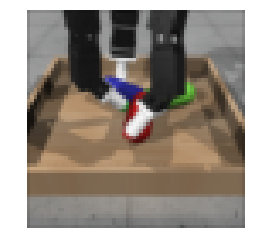


========== IMAGE # 11 =========
POS (cm) ERROR: 1.685913513884402

true: [-0.81658171 -0.59741907  0.80391973  0.59473781]
pred: [-0.70704305 -0.57224476  0.76659876  0.6632243 ]


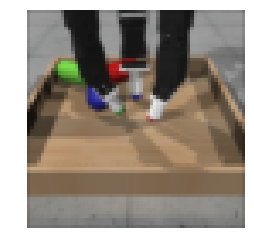


========== IMAGE # 12 =========
POS (cm) ERROR: 1.6397383968131323

true: [-0.55050301  0.58815357 -0.13737815 -0.99051867]
pred: [-0.65975773  0.59181017 -0.08942374 -0.97648275]


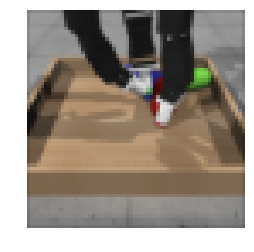


========== IMAGE # 13 =========
POS (cm) ERROR: 1.5439739439415294

true: [-0.59110683  0.51151731 -0.62368122 -0.78167879]
pred: [-0.69079864  0.5371387  -0.68460715 -0.66161585]


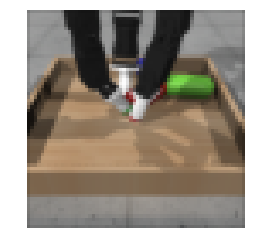


========== IMAGE # 14 =========
POS (cm) ERROR: 1.4931397759247316

true: [-0.56967968  0.58094751  0.83057525  0.55690641]
pred: [-0.47176903  0.5988987   0.90926325  0.4435255 ]


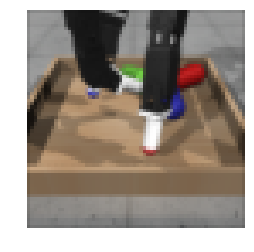


========== IMAGE # 15 =========
POS (cm) ERROR: 1.4893922451271655

true: [-0.59670801  0.58206578  0.40103938  0.91606082]
pred: [-0.6280004   0.67629874  0.5015027   0.8396598 ]


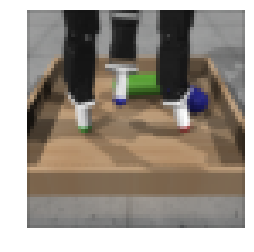


========== IMAGE # 16 =========
POS (cm) ERROR: 1.4821852318560929

true: [-0.72776718  0.55768729 -0.26430327 -0.96443962]
pred: [-0.7231382   0.45898342 -0.14123742 -0.95733017]


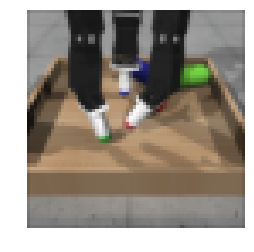


========== IMAGE # 17 =========
POS (cm) ERROR: 1.475148381200729

true: [-0.44342523 -0.61671466  0.9898898  -0.14183861]
pred: [-0.535251   -0.58150935  0.9589277  -0.2295585 ]


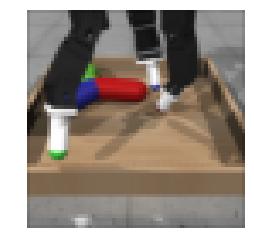


========== IMAGE # 18 =========
POS (cm) ERROR: 1.4642744136535608

true: [-0.71407945  0.6669346  -0.92461993  0.38089104]
pred: [-0.8076294   0.69482255 -0.9199717   0.3664828 ]


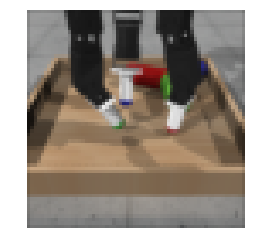


========== IMAGE # 19 =========
POS (cm) ERROR: 1.462713960426933

true: [0.12820805 0.38360028 0.63108258 0.77571565]
pred: [0.04017849 0.34164998 0.58460855 0.85589886]


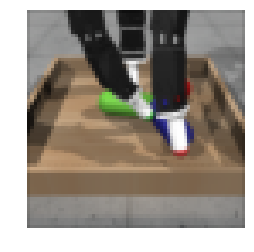

[2687 6802 1194 5518 4112  430 7422 2144 5330  435  665 6986  574 4613
 3036 2553 8007 2233 3968 7726]

========== IMAGE # 0 =========
ANGLE (degrees) ERROR: 14.401389916930398

true: [-0.68584427  0.54138879 -0.59593465  0.80303293]
pred: [-0.61252666  0.52391326 -0.345418    0.8473551 ]


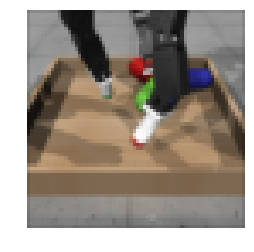


========== IMAGE # 1 =========
ANGLE (degrees) ERROR: 12.33243777000375

true: [-0.51575426  0.64643745  0.05253635 -0.99861901]
pred: [-0.49666056  0.5752082   0.25932297 -0.94507706]


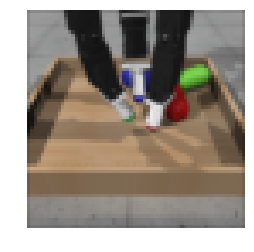


========== IMAGE # 2 =========
ANGLE (degrees) ERROR: 12.30417979987537

true: [-0.55063652 -0.23332699 -0.7566394  -0.65383241]
pred: [-0.567191   -0.30950937 -0.60259485 -0.8036135 ]


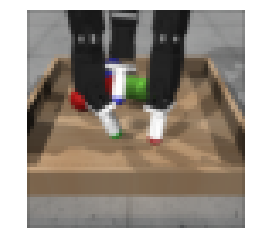


========== IMAGE # 3 =========
ANGLE (degrees) ERROR: 11.640397791495616

true: [-0.78686015 -0.57366342  0.19005715 -0.98177303]
pred: [-0.7329514  -0.5273967  -0.01156454 -0.9682724 ]


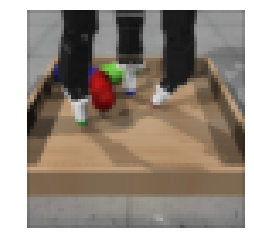


========== IMAGE # 4 =========
ANGLE (degrees) ERROR: 11.55226627427328

true: [-0.4850533   0.59162643 -0.78698922  0.61696674]
pred: [-0.56629825  0.56250125 -0.64743805  0.7620091 ]


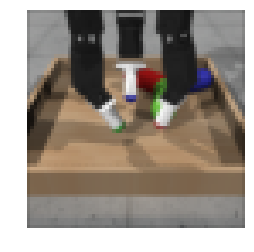


========== IMAGE # 5 =========
ANGLE (degrees) ERROR: 10.398607951783262

true: [-0.76033253  0.56251785 -0.23967703 -0.97085268]
pred: [-0.7049663   0.5685433  -0.05972397 -0.9852625 ]


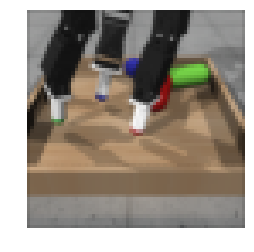


========== IMAGE # 6 =========
ANGLE (degrees) ERROR: 10.387071034734618

true: [-0.68876094 -0.70119908 -0.33665398 -0.94162843]
pred: [-0.60886115 -0.70260566 -0.5007045  -0.86514413]


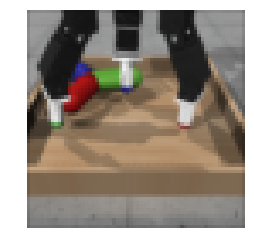


========== IMAGE # 7 =========
ANGLE (degrees) ERROR: 10.313107426582505

true: [-0.25210576  0.39885278  0.01326351 -0.99991204]
pred: [-0.24909283  0.44982788 -0.1646077  -0.978083  ]


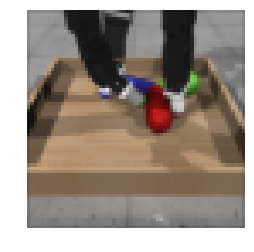


========== IMAGE # 8 =========
ANGLE (degrees) ERROR: 9.970996228928172

true: [-0.3518207  -0.05668984 -0.34156294  0.9398589 ]
pred: [-0.4151768  -0.10832221 -0.4969419   0.86270523]


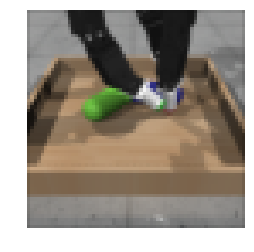


========== IMAGE # 9 =========
ANGLE (degrees) ERROR: 9.742800394059387

true: [-0.40183035  0.24406905 -0.42845103 -0.903565  ]
pred: [-0.43482947  0.31108534 -0.5793642  -0.82398176]


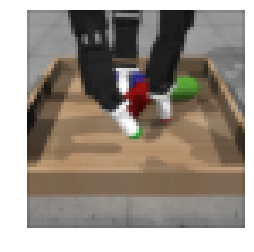


========== IMAGE # 10 =========
ANGLE (degrees) ERROR: 9.373492290672118

true: [-0.18087658 -0.34216298 -0.75963869  0.65034534]
pred: [-0.17601998 -0.28999162 -0.65298545  0.7765762 ]


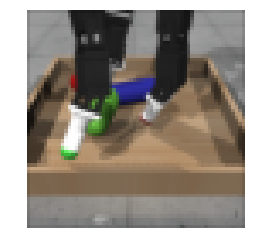


========== IMAGE # 11 =========
ANGLE (degrees) ERROR: 9.266309322028931

true: [-0.54405708  0.55047068 -0.32402873 -0.94604724]
pred: [-0.6035142   0.6208888  -0.46770096 -0.8732445 ]


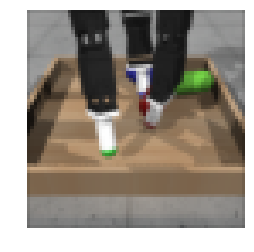


========== IMAGE # 12 =========
ANGLE (degrees) ERROR: 9.167634547223106

true: [-0.66610772 -0.5795647   0.99118832  0.13246022]
pred: [-0.6914266  -0.6667435   0.9683565   0.29198453]


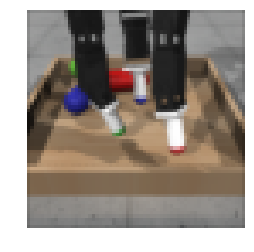


========== IMAGE # 13 =========
ANGLE (degrees) ERROR: 8.946928599944215

true: [-0.21129018 -0.52081497 -0.57383255  0.81897265]
pred: [-0.16761194 -0.5299022  -0.6954614   0.7210561 ]


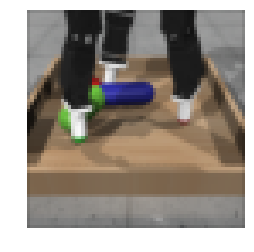


========== IMAGE # 14 =========
ANGLE (degrees) ERROR: 8.887392107208711

true: [-0.55206599 -0.0016937  -0.96899954 -0.24706251]
pred: [-0.5368948   0.03408733 -0.97429097 -0.09237833]


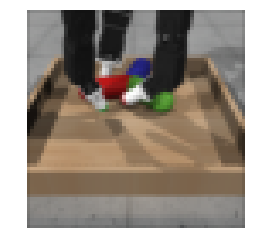


========== IMAGE # 15 =========
ANGLE (degrees) ERROR: 8.525578413823652

true: [0.26419027 0.64861664 0.34726091 0.93776855]
pred: [0.27813992 0.6437928  0.20341586 0.9741818 ]


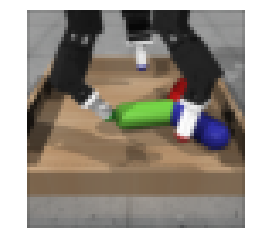


========== IMAGE # 16 =========
ANGLE (degrees) ERROR: 8.491665691330851

true: [ 0.64934138 -0.27257831  0.99863599 -0.0522127 ]
pred: [ 0.6786561  -0.3443125   0.9653831   0.09293436]


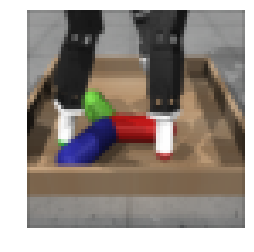


========== IMAGE # 17 =========
ANGLE (degrees) ERROR: 8.439851937789541

true: [-0.37161274 -0.43042728 -0.27034852 -0.96276252]
pred: [-0.33941972 -0.42208806 -0.41381565 -0.9240207 ]


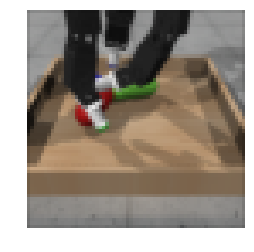


========== IMAGE # 18 =========
ANGLE (degrees) ERROR: 8.32662153504981

true: [-0.39677403 -0.06709939  0.07201304  0.99740369]
pred: [-0.35896233 -0.09466991 -0.07118662  0.97007126]


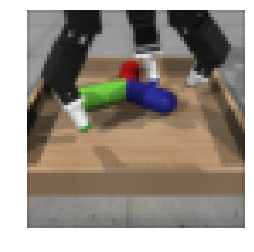


========== IMAGE # 19 =========
ANGLE (degrees) ERROR: 8.278441533110808

true: [-0.46980651 -0.59289255  0.79172928  0.61087212]
pred: [-0.52076435 -0.5616367   0.67475486  0.69704795]


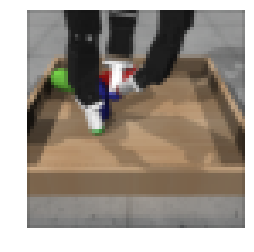

In [16]:
display_top_errors(pos_errors, label_str="POS (cm)")
display_top_errors(angle_errors, label_str="ANGLE (degrees)")

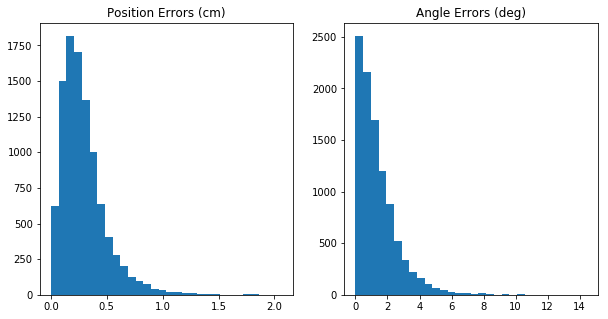

In [17]:
def plot_histograms(pos_errors, angle_errors):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Position Errors (cm)')
    plt.hist(pos_errors, bins=30)
    plt.subplot(1, 2, 2)
    plt.title('Angle Errors (deg)')
    plt.hist(angle_errors, bins=30)
    plt.show()
    
plot_histograms(pos_errors, angle_errors)

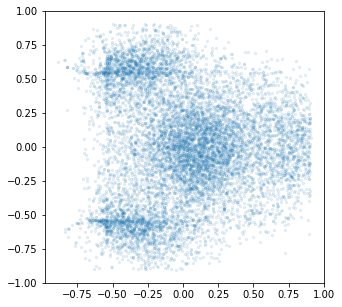

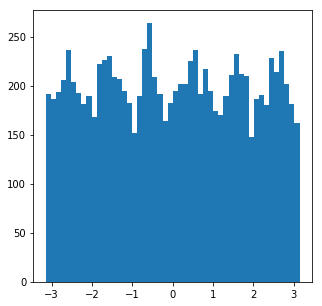

In [18]:
def plot_pos_support():
    plt.figure(figsize=(5, 5))
    plt.scatter(test_labels[:, 0], test_labels[:, 1], alpha=0.1, s=5)
    plt.show()
    
plot_pos_support()

def plot_angle_support():
    plt.figure(figsize=(5,5))
    angles = np.arctan2(test_labels[:, 3], test_labels[:, 2])
    plt.hist(angles, bins=50)
    plt.show()
    
plot_angle_support()

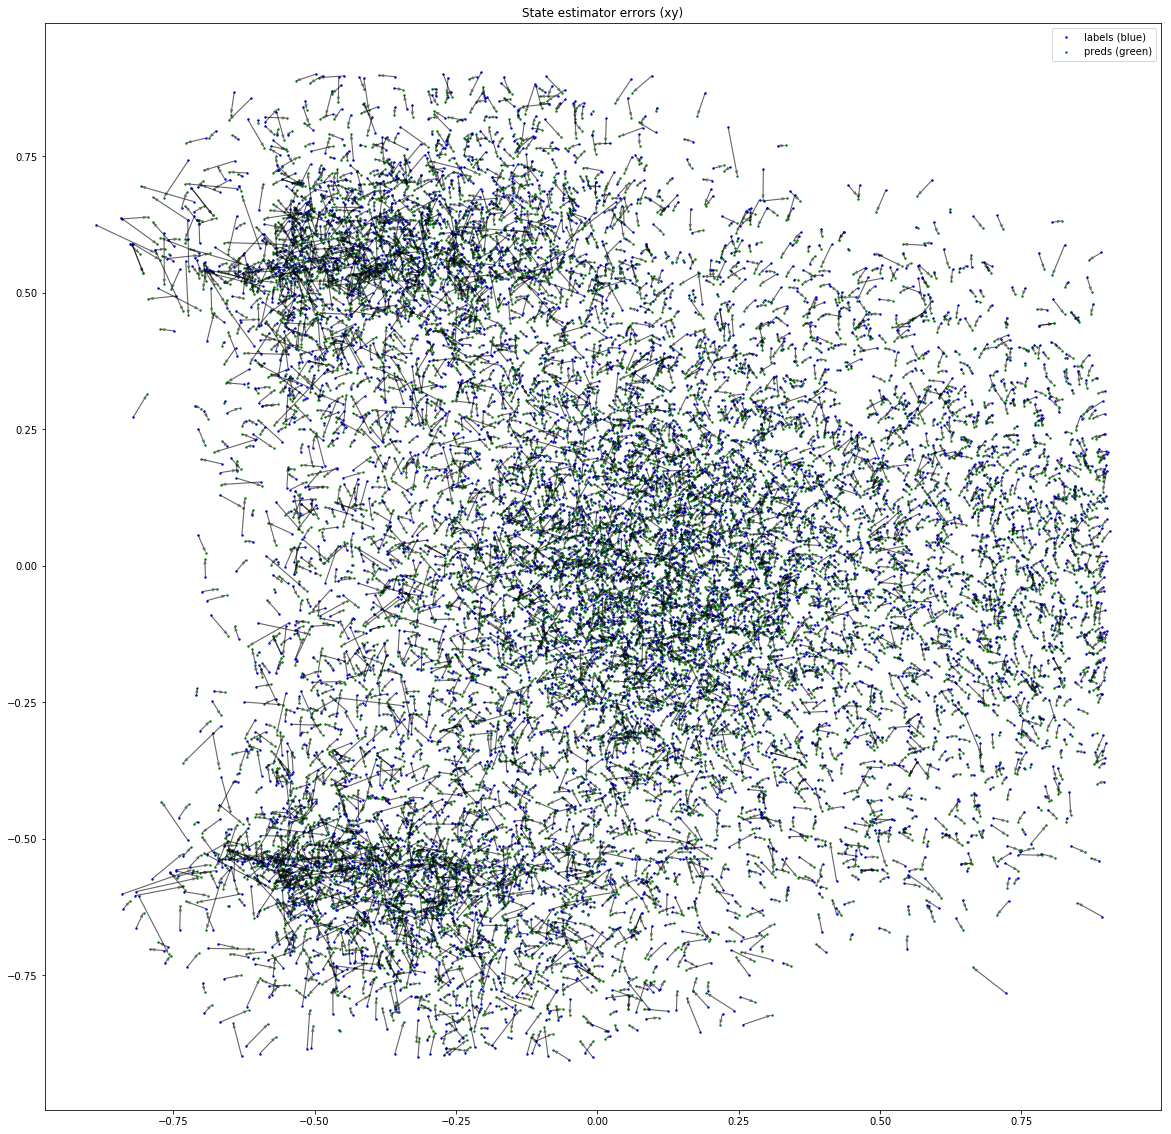

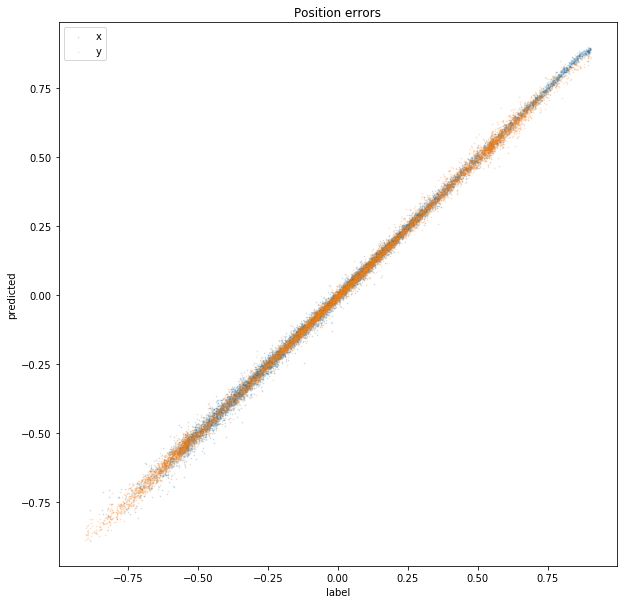

In [19]:
def get_noise(size, loc=0, scale=0.02):
    return np.random.normal(loc=loc, scale=scale, size=size)

labels_x, labels_y = test_labels[:, 0], test_labels[:, 1]

preds_x, preds_y = preds[:, 0], preds[:, 1]
dxs, dys = preds_x - labels_x, preds_y - labels_y
plt.figure(figsize=(20, 20))
plt.title('State estimator errors (xy)')

plt.scatter(labels_x, labels_y, c='blue', s=2, label='labels (blue)')
plt.scatter(preds_x, preds_y, c='green', s=2, label='preds (green)')
plt.legend()
plt.quiver(labels_x, labels_y, dxs, dys, angles='xy', scale_units='xy', scale=1, width=0.001, alpha=0.6)

plt.figure(figsize=(10, 10))
plt.title('Position errors')
plt.xlabel('label')
plt.ylabel('predicted')

plt.scatter(labels_x, preds_x, s=0.5, alpha=0.2, label='x')
plt.scatter(labels_y, preds_y, s=0.5, alpha=0.2, label='y')
plt.legend()

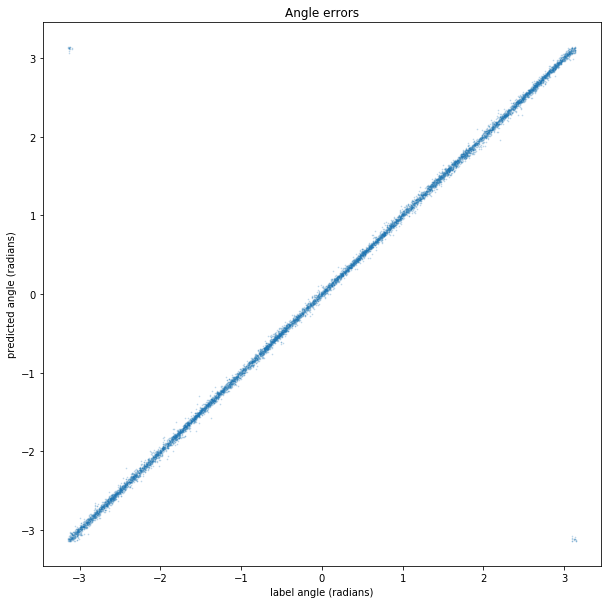

In [20]:
labels_z_cos, labels_z_sin = test_labels[:, 2], test_labels[:, 3]
preds_z_cos, preds_z_sin = preds[:, 2], preds[:, 3]
dzs_cos, dzs_sin = preds_z_cos - labels_z_cos, preds_z_sin - labels_z_sin

labels_angle, preds_angle = (
    np.arctan2(labels_z_sin, labels_z_cos),
    np.arctan2(preds_z_sin, preds_z_cos)
)
plt.figure(figsize=(10, 10))
plt.title('Angle errors')
plt.xlabel('label angle (radians)')
plt.ylabel('predicted angle (radians)')
plt.scatter(labels_angle, preds_angle, s=0.4, alpha=0.25)

In [22]:
vae = state_estimator.get_layer('vae_preprocessor')
test_vae_output = vae(test_images[0][None])

In [23]:
np.mean(test_vae_output), np.std(test_vae_output)

(0.0678919, 0.39112645)